# Prediction <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

## Background

stuff

## Description
1. Generate predictions using out imported model at a number of test locations.
2. Plot the results of our test locations (assuming the test locations aren't too large).
3. Generate a large-scale classification

### Load Packages

In [ ]:
# !pip install richdem
# !pip install https://packages.dea.ga.gov.au/hdstats/hdstats-0.1.5.tar.gz
# !pip install dask-ml

In [1]:
import sys
import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
import subprocess as sp
from joblib import load
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.cog import write_cog
from datacube.utils.geometry import assign_crs
from sklearn.preprocessing import StandardScaler
from odc.algo import xr_geomedian, int_geomedian

sys.path.append('../../Scripts')
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster
from deafrica_classificationtools import HiddenPrints
from deafrica_plotting import rgb, display_map, map_shapefile
from deafrica_classificationtools import HiddenPrints, predict_xr
from deafrica_spatialtools import xr_rasterize, xr_vectorize

from feature_layer_functions import gm_mads_two_seasons

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)
/env/lib/python3.6/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/env/lib/python3.6/site-packages/branca/colormap.py:29: ResourceWarning: unclosed file <_io.BufferedReader name='/env/lib/python3.6/site-packages/branca/_cnames.json'>
  resource_package, resource_path_cnames).read().decode()
/env/li

### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:39495 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 31 Memory: 254.70 GB


## Analysis parameters

* `model_path`: The path to the location where the model exported from the previous notebook is stored
* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `features_scaled`: 
* `sc_path`: Use this parameter to indicate whether or not the features where scaled using the `standardScalar()` method in the previous notebook. If you did scale the features then provide the path to the `standardScalar` values output in the previous notebook. Otherwise, set this parameters to `None`
* `test_shapefile`: A shapefile containing polygons that represent regions where you want to test your model. The shapefile should have a unique identifier as this will be used to export classification results to disk as geotiffs.
* `results`: A folder location to store the classified geotiffs 

In [3]:
model_path = 'results/gm_mads_two_seasons_ml_model.joblib'

training_data = "results/training_data/gm_mads_two_seasons_training_data.txt"

sc_path = None #'results/std_scaler.bin'

test_shapefile = 'data/eastern_testing_sites.geojson'

results = 'results/classifications/'

model_type='gm_mads_two_seasons'

### Connect to the datacube

In [4]:
dc = datacube.Datacube(app='prediction')

### Open and inspect test_shapefile

In [5]:
gdf = gpd.read_file(test_shapefile)

# gdf.head()
map_shapefile(gdf, attribute='GRID_ID')

Label(value='')

Map(center=[1.7501522238596312, 35.899982256111464], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Open the model

If we ran the optional feature scaling method in the `3_Train_fit_evaluate_classifier.ipynb`, then we will also load in the standard scalar values.

The code below will also re-open the training data we exported from `2_Inspect_training_data.ipynb` and grab the column names (features we selected).

In [6]:
model = load(model_path)

In [7]:
# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[2:]
print(column_names)

['red_S1', 'blue_S1', 'green_S1', 'nir_S1', 'swir_1_S1', 'swir_2_S1', 'red_edge_1_S1', 'red_edge_2_S1', 'red_edge_3_S1', 'edev_S1', 'sdev_S1', 'bcdev_S1', 'NDVI_S1', 'LAI_S1', 'MNDWI_S1', 'rain_S1', 'red_S2', 'blue_S2', 'green_S2', 'nir_S2', 'swir_1_S2', 'swir_2_S2', 'red_edge_1_S2', 'red_edge_2_S2', 'red_edge_3_S2', 'edev_S2', 'sdev_S2', 'bcdev_S2', 'NDVI_S2', 'LAI_S2', 'MNDWI_S2', 'rain_S2', 'slope']


## Making a prediction


### Set up datacube query

These query options should match the query params in `1_Extract_training_data.ipynb`, unless there are measurements that no longer need to be loaded because they were dropped during the feature selection process.

In [8]:
#set up our inputs to collect_training_data
products =  ['s2_l2a']
time = ('2019-01','2019-12')

# Set up the inputs for the ODC query
measurements =  ['red','blue','green','nir','swir_1','swir_2','red_edge_1','red_edge_2', 'red_edge_3']
resolution = (-20,20)
output_crs='epsg:6933'
dask_chunks={'x':2000,'y':2000,'time':1}

### Loop through test tiles and predict

For every tile we list in the `test_shapefile`, we calculate the feature layers, and then use the DE Africa function `predict_xr` to classify the data.

The results are exported to file as Cloud-Optimised Geotiffs.

In [9]:
predictions = []

for index, row in gdf.iterrows():
    
    #get id for labelling
    g_id=gdf.iloc[index]['GRID_ID']
    print('working on grid: ' + g_id)
    
    # Get the geometry
    geom = geometry.Geometry(row.geometry.__geo_interface__,
                             geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))

     # generate a datacube query object
    query = {
        'time': time,
        'measurements': measurements,
        'resolution': resolution,
        'output_crs': output_crs,
        'group_by' : 'solar_day',
    }
    
    # Update dc query with geometry      
    query.update({'geopolygon': geom}) 
    
    #load data
    with HiddenPrints():
        ds = load_ard(dc=dc,
                      products=products,
                      dask_chunks=dask_chunks,
                      **query)

    #calculate features
    data = gm_mads_two_seasons(ds)
    #predict using the imported model
    predicted = predict_xr(model,
                           data,
                           #proba=True,
#                            persist=True,
                           clean=True,
#                            return_input=True
                          ).compute()
    
    # Mask dataset to set pixels outside the polygon to `NaN`
#     with HiddenPrints():
#         mask = xr_rasterize(gdf.iloc[[index]], ds)
#         predicted = predicted.where(mask)
    
    predictions.append(predicted)
        
    #export classifications to disk
    write_cog(predicted.Predictions, results+ 'Eastern_tile_'+g_id+'_prediction_pixel_'+model_type+'_new.tif', overwrite=True)
    
    #export layer for running image segmentation
#     write_cog(predicted.NDVI_S1, results+ 'Eastern_tile_'+g_id+'_NDVI_S1.tif', overwrite=True)
    

working on grid: E-20
   predicting...
working on grid: B-19
   predicting...


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-ac5ed1523adc>", line 39, in <module>
    clean=True,
  File "/env/lib/python3.6/site-packages/xarray/core/dataset.py", line 819, in compute
    return new.load(**kwargs)
  File "/env/lib/python3.6/site-packages/xarray/core/dataset.py", line 654, in load
    evaluated_data = da.compute(*lazy_data.values(), **kwargs)
  File "/env/lib/python3.6/site-packages/dask/base.py", line 452, in compute
    results = schedule(dsk, keys, **kwargs)
  File "/env/lib/python3.6/site-packages/distributed/client.py", line 2714, in get
    results = self.gather(packed, asynchronous=asynchronous, direct=direct)
  File "/env/lib/python3.6/site-packages/distributed/client.py", line 1993, in gather
    asynchronous=asynchronous,
  File "/env/lib/python3.6/site-packages/distributed/client.py", line 834


KeyboardInterrupt



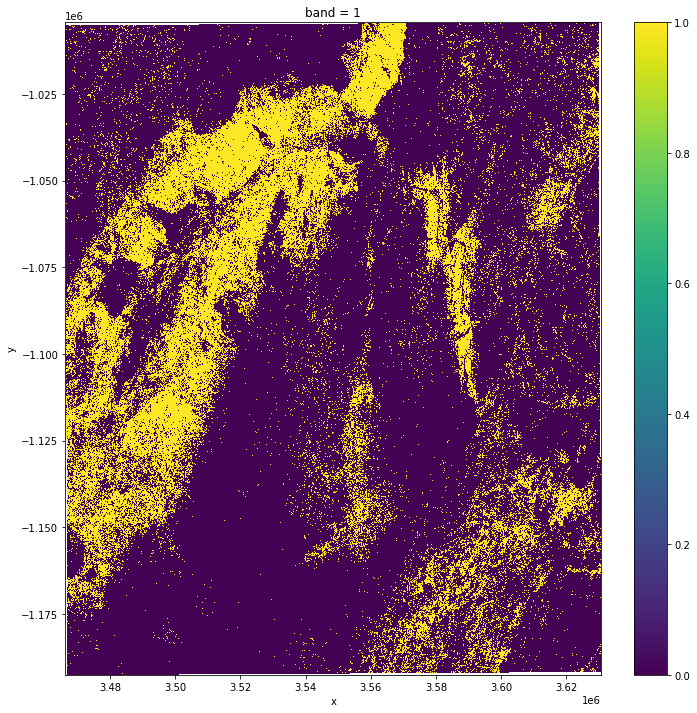

In [10]:
import xarray as xr
x=xr.open_rasterio(results+ 'Eastern_tile_'+'E-20'+'_prediction_pixel_'+model_type+'.tif').squeeze()
x.plot(figsize=(12, 12));